In [23]:
import pandas as pd
import os
import glob
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Markdown
import seaborn as sns
import numpy as np

from metadata.etfs import etfs_large, etfs_small
from utils.conn_data import load_pickle

plt.style.use('seaborn')

In [24]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "src", "data", "outputs")
des = pd.read_csv(os.path.join(os.getcwd(), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [65]:
warnings.simplefilter("ignore")


all_metrics = []
all_rolling_metrics = []
all_stability = []
all_parents = []
for fs in fs_methods:

    if plot_ts:
        display(Markdown(f"## {fs}"))

    # list results files with glob
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    # load results files
    stability = []
    metrics = []
    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]

        if (etf_focus != etf) and (etf_focus is not None):
            continue
        else:
            pass

        obj = load_pickle(path=file)

        # plot predictions
        predictions_df = obj['predictions']
        predictions_2020_df = predictions_df.loc["2020-01-01":"2020-12-01"]

        if plot_ts:
            fig, ax = plt.subplots(figsize=(10, 5))
            ax.set_title(label=f'OOS Predictions for {etf}', fontsize=15)
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["prediction"], label="predictions")
            ax.plot(pd.to_datetime(predictions_df.index), predictions_df["true"], label="true")
            plt.xlabel("Date")
            plt.ylabel("Returns")
            plt.legend(loc='best', fontsize=10)   
            plt.show()

        # compute rolling mse
        rolling_metric_df = predictions_df.copy()
        rolling_metric_df["diff"] = rolling_metric_df["true"] - rolling_metric_df["prediction"]

        # rolling mse
        rolling_metric_df["rolling_var"] = rolling_metric_df["prediction"].rolling(12).var()
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["true"] - rolling_metric_df["prediction"].rolling(12).mean()).pow(2)
        rolling_metric_df["rolling_mse"] = rolling_metric_df["rolling_var"] + rolling_metric_df["rolling_bias"]
        rolling_metric_df["rolling_var"] = (rolling_metric_df["rolling_var"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df["rolling_bias"] = (rolling_metric_df["rolling_bias"] / rolling_metric_df["rolling_mse"]) * 100
        rolling_metric_df = rolling_metric_df[["rolling_mse", "rolling_var", "rolling_bias"]]

        # add info
        rolling_metric_df["fs"] = fs
        rolling_metric_df["etf"] = etf

        # melt
        melt_rolling_metric_df = rolling_metric_df.reset_index().melt(["date", "fs", "etf"])

        # compute forecast metrics
        mse = mean_squared_error(predictions_df["true"], predictions_df["prediction"])
        mae = mean_absolute_error(predictions_df["true"], predictions_df["prediction"])
        mse_2020 = mean_squared_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        mae_2020 = mean_absolute_error(predictions_2020_df["true"], predictions_2020_df["prediction"])
        # bias = (predictions_df["true"] - np.mean(predictions_df["prediction"], axis=1)) ** 2
        # var = np.var(predictions_df["prediction"], axis=1)

        # compute cluster stability metrics
        parents_of_target_df = obj["parents_of_target"]

        # save parents
        parents_of_target_df["fs"] = fs
        parents_of_target_df["etf"] = etf
        
        tot = len(parents_of_target_df["date"].unique())
        stability_df = (parents_of_target_df.fillna(0).groupby(["cluster"]).sum()[["value"]] / tot).sort_values(by="value", ascending=False)
        stability_df = pd.concat({etf: stability_df}, names=['etf'])
        stability.append(stability_df)

        stability_measure = (stability_df).sum().iloc[0] / stability_df.shape[0]
        metrics_df = pd.DataFrame({
            "fs": fs, 
            "etf": etf, 
            "mse": [mse],
            "mae": [mae], 
            # "bias": [bias],
            # "var": [var],
            "mse_2020": [mse_2020], 
            "mae_2020": [mae_2020],
            "stability": stability_measure})
        metrics.append(metrics_df)
        all_rolling_metrics.append(melt_rolling_metric_df)
        all_parents.append(parents_of_target_df)
    
    all_metrics.append(pd.concat(metrics).set_index(["fs", "etf"]))
    all_stability.append(pd.concat(stability))
all_metrics_df = pd.concat(all_metrics)
all_rolling_metrics_df = pd.concat(all_rolling_metrics)
all_parents_df = pd.concat(all_parents)
melted_all_metrics_df = all_metrics_df.reset_index().melt(id_vars=["fs", "etf"])

## Boxplots with summary statistics

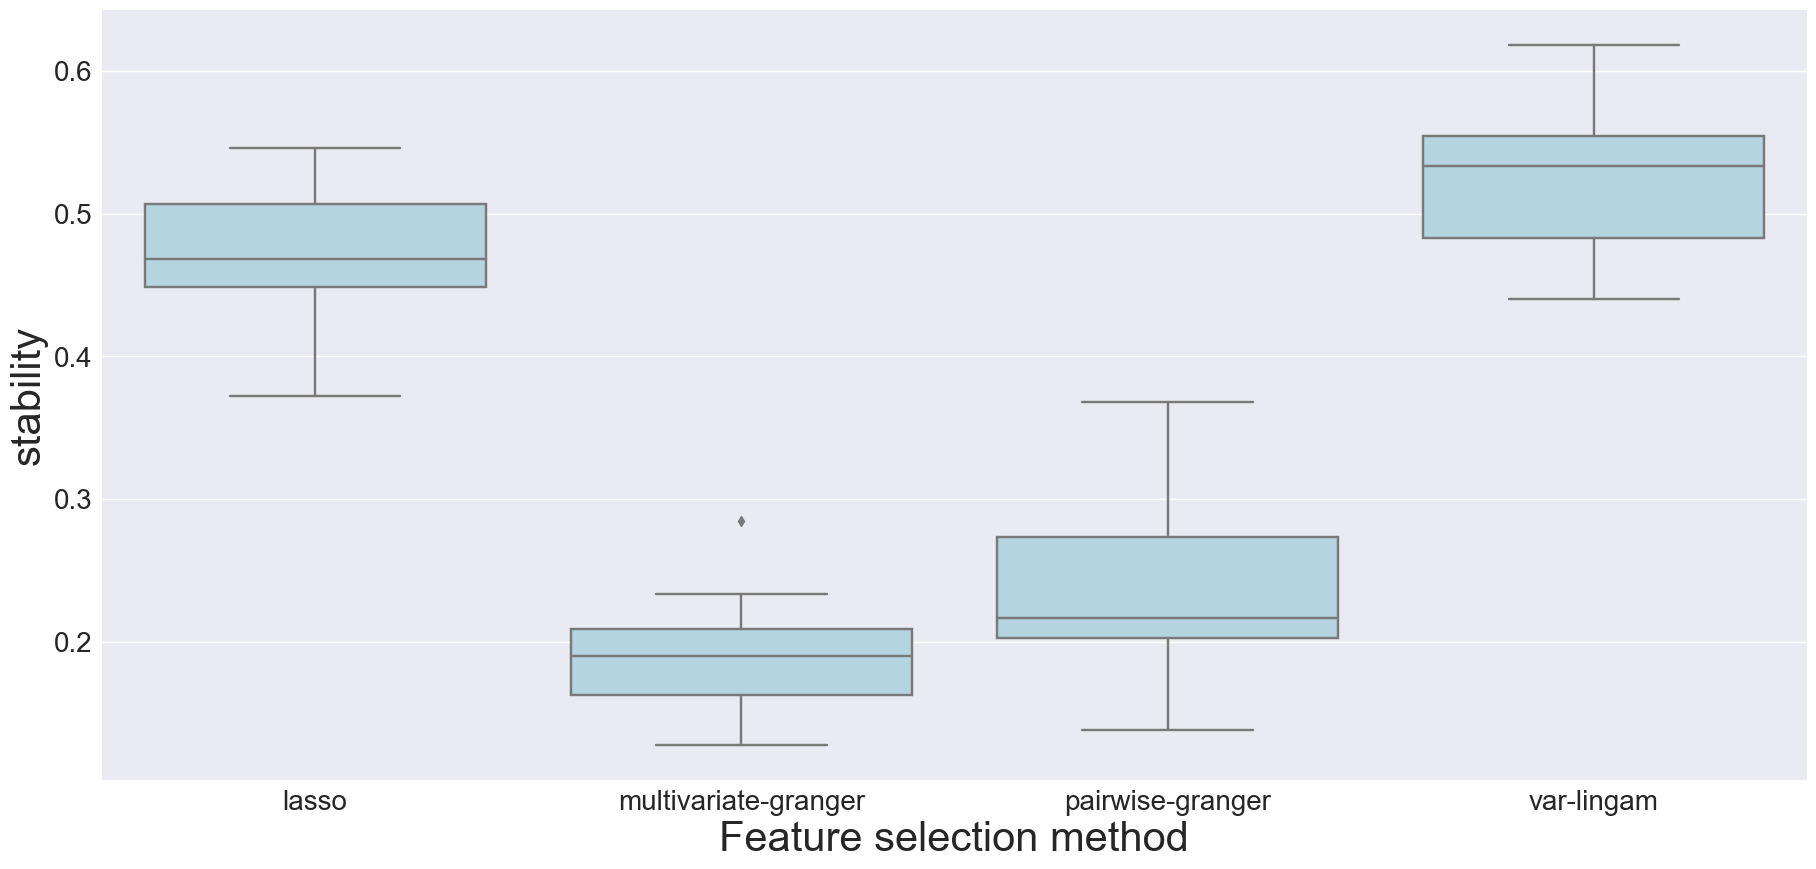

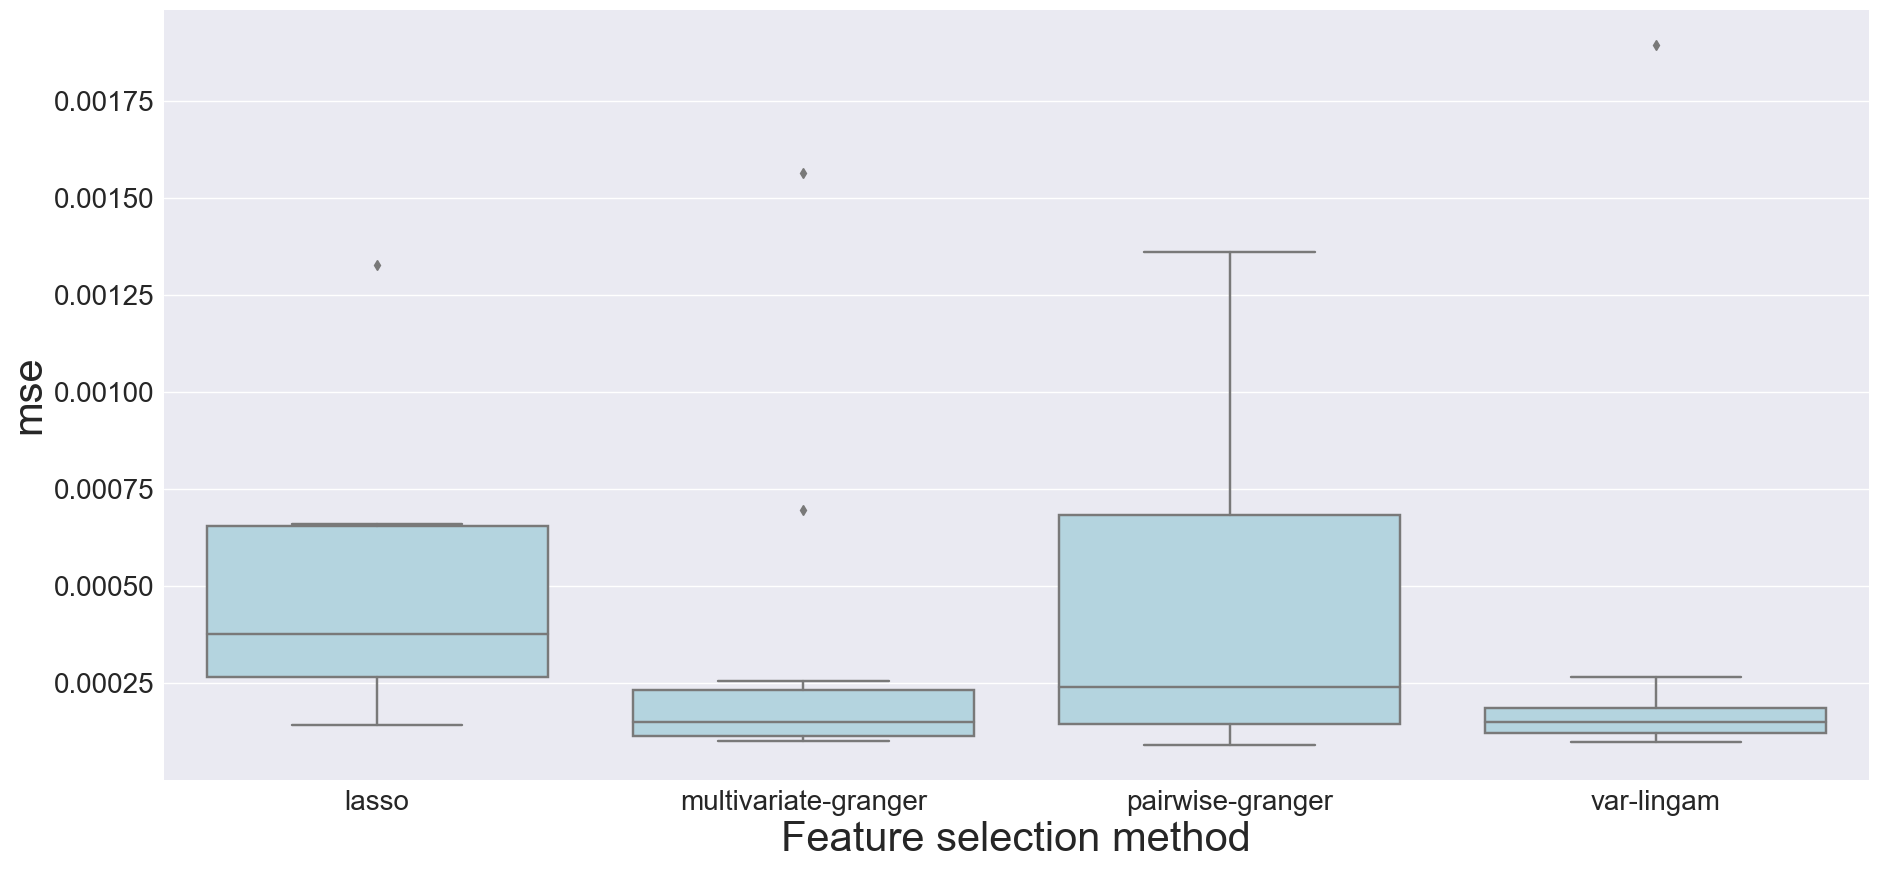

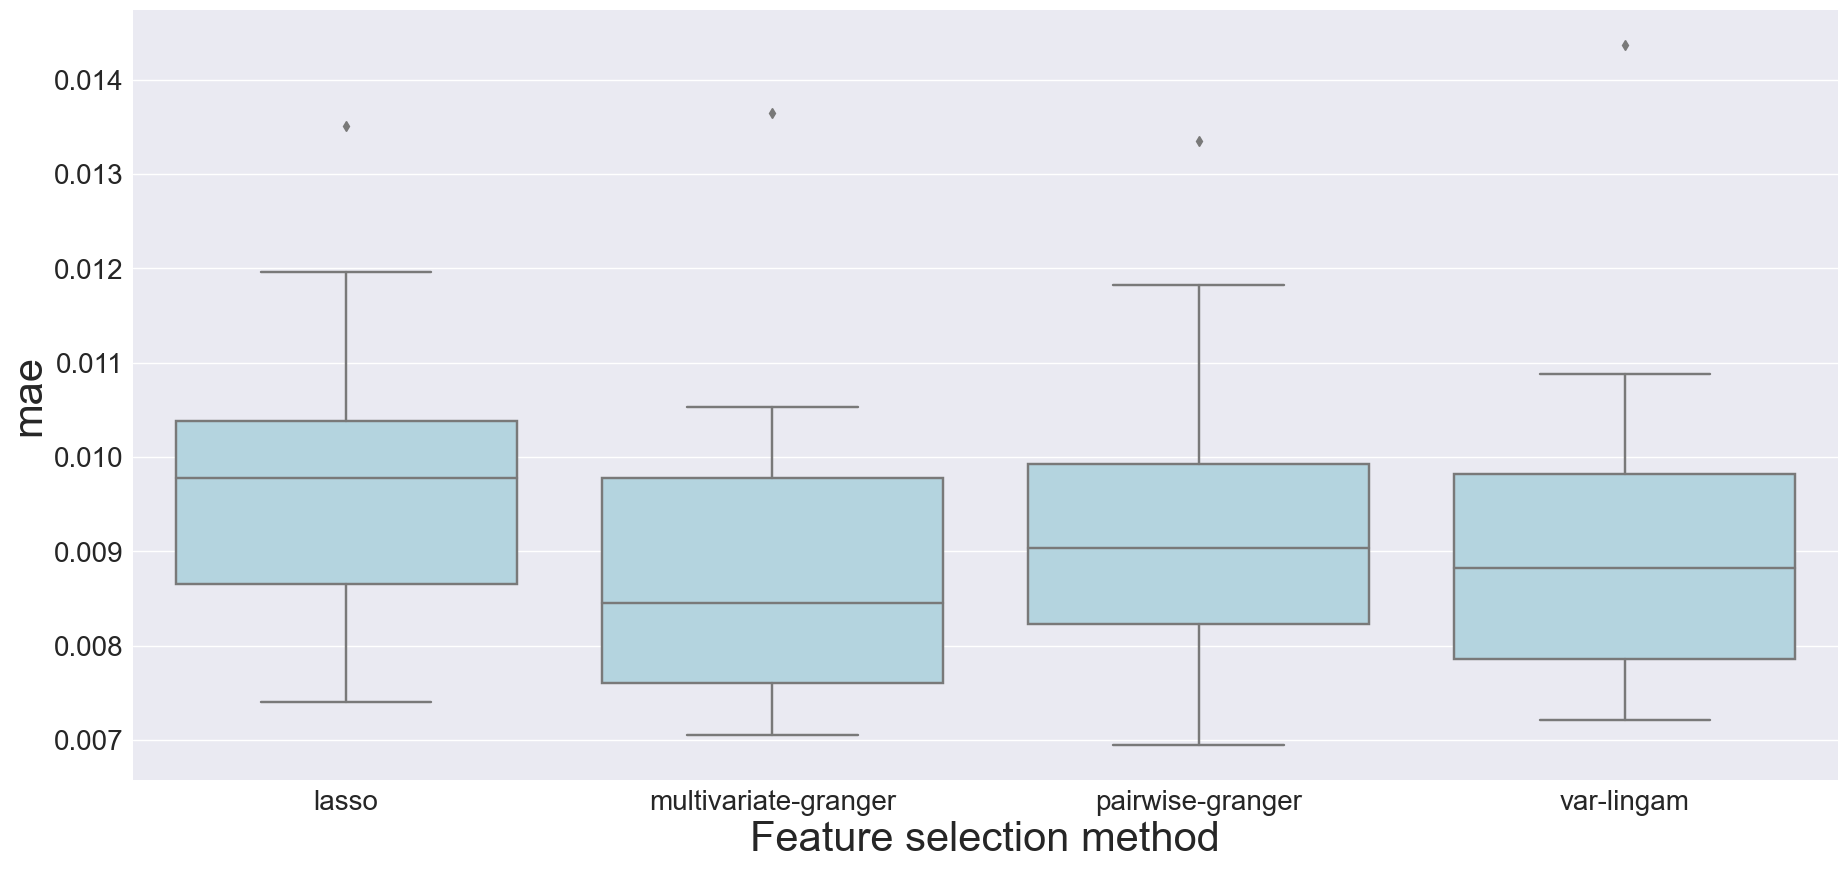

In [66]:
metric_name = "mse"
for m in metric_names:
    boxplot_df = melted_all_metrics_df.loc[(melted_all_metrics_df["variable"] == m)].drop(["variable"], axis=1)

    fig, ax = plt.subplots(figsize=(22, 10))
    sns.boxplot(x="fs", y='value',data=boxplot_df, ax=ax, color='lightblue')
    ax.set_ylabel(m, fontsize=30)
    ax.set_xlabel("Feature selection method", fontsize=30)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    # ax.legend(loc="best",fontsize=15)
    # fig.savefig('img/oos_auc_fs_methods_distr.png')

### Prediction error over time

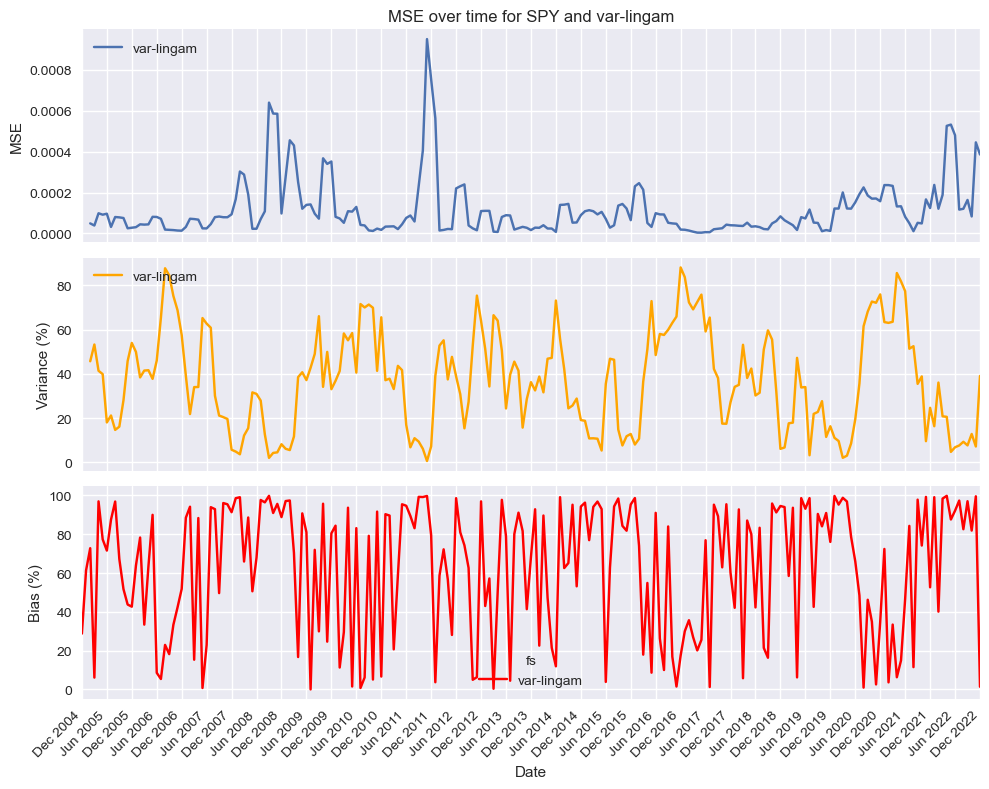

In [71]:
etf = "SPY"
fs = "var-lingam"

# mse
etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
etf_rolling_metrics_df["diff_lasso_var-lingam"] = 1

# variance
etf_rolling_variance_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_var")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel()
etf_rolling_variance_df = etf_rolling_variance_df.rolling(3).mean()
etf_rolling_variance_df.columns = etf_rolling_variance_df.columns.droplevel(1) 

# bias
etf_rolling_bias_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["fs"] == fs)&(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_bias")].pivot_table(index=["date"], columns=["fs", "variable"], values=["value"])
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel()
etf_rolling_biass_df = etf_rolling_bias_df.rolling(3).mean()
etf_rolling_bias_df.columns = etf_rolling_bias_df.columns.droplevel(1) 

# plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# plotting on the upper subplot
etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
axs[0].set_title(f'MSE over time for {etf} and {fs}')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='upper left')

# plotting on the upper subplot
etf_rolling_variance_df.plot(ax=axs[1], color="orange")
# axs[1].set_title(f'Variance over time for {etf}')
axs[1].set_ylabel('Variance (%)')
axs[1].legend(loc='upper left')

# plotting on the lower subplot
etf_rolling_bias_df.plot(ax=axs[2], color="red")
# axs[2].set_title(f'Bias over time for {etf}')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Bias (%)')

# adding months and years to the index of the plot
tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
axs[2].set_xticks(tick_positions)
axs[2].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

# adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

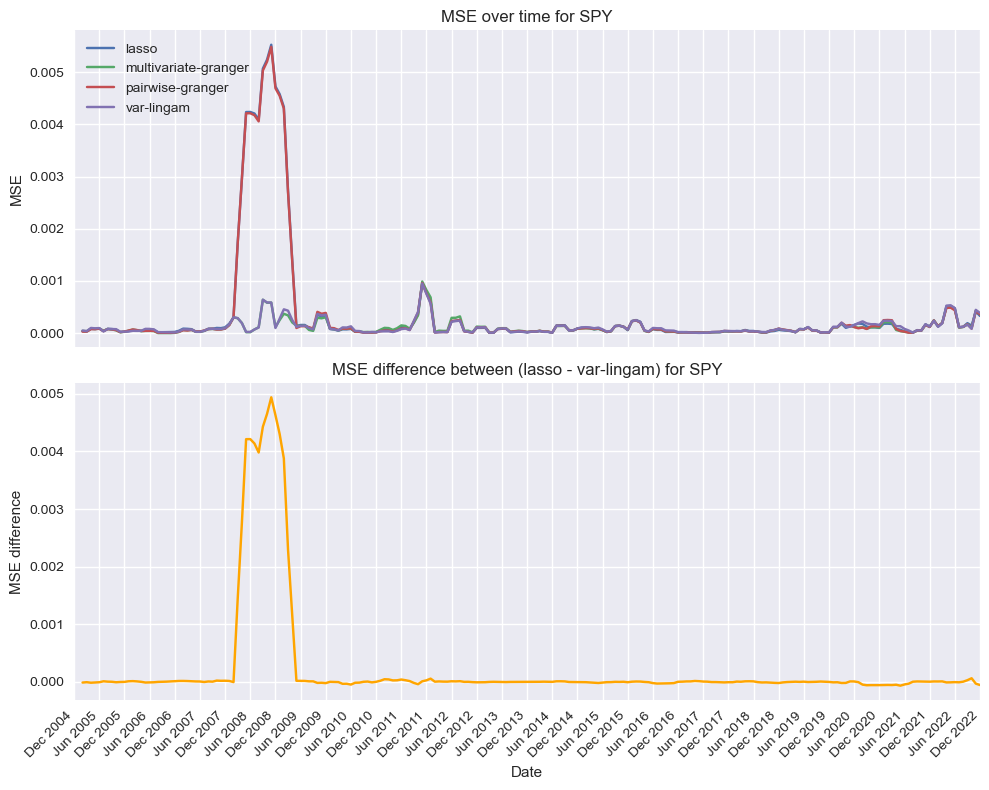

In [68]:
# SPY, XLP, XLK, XLY, XLF, XLB, XLI 

for etf in ["SPY"]:# all_rolling_metrics_df["etf"].unique():
    etf_rolling_metrics_df = all_rolling_metrics_df.loc[(all_rolling_metrics_df["etf"] == etf)&(all_rolling_metrics_df["variable"]=="rolling_mse")].pivot_table(index=["date"], columns=["fs"], values=["value"])
    etf_rolling_metrics_df.columns = etf_rolling_metrics_df.columns.droplevel()
    etf_rolling_metrics_df = etf_rolling_metrics_df.rolling(3).mean()
    etf_rolling_metrics_df["diff_lasso_var-lingam"] = etf_rolling_metrics_df["lasso"] - etf_rolling_metrics_df["var-lingam"]

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plotting on the upper subplot
    etf_rolling_metrics_df.drop(["diff_lasso_var-lingam"], axis=1).plot(ax=axs[0])
    axs[0].set_title(f'MSE over time for {etf}')
    axs[0].set_ylabel('MSE')
    axs[0].legend(loc='upper left')

    # Plotting on the lower subplot
    etf_rolling_metrics_df["diff_lasso_var-lingam"].plot(ax=axs[1], color='orange')
    axs[1].set_title(f'MSE difference between (lasso - var-lingam) for {etf}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('MSE difference')

    # Adding months and years to the index of the plot
    tick_positions = etf_rolling_metrics_df.index[::6]  # Show every 6th date
    axs[1].set_xticks(tick_positions)
    axs[1].set_xticklabels(tick_positions.strftime('%b %Y'), rotation=45, ha='right')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

## Selected parents over time

In [10]:
etf = "SPY"
fss = ["var-lingam", "multivariate-granger"]

In [11]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[0]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                                         \
etf               SPY                                                          
fs         var-lingam                                                          
cluster          2.0  4.0  5.0  6.0  7.0  8.0  10.0 12.0 14.0 15.0 16.0 17.0   
date                                                                           
2020-01-31        NaN  NaN  NaN  NaN  1.0  1.0  NaN  NaN  NaN  1.0  1.0  NaN   
2020-02-29        NaN  NaN  NaN  NaN  1.0  1.0  NaN  NaN  NaN  1.0  1.0  NaN   
2020-03-31        NaN  NaN  NaN  NaN  1.0  1.0  NaN  NaN  NaN  1.0  1.0  NaN   
2020-04-30        NaN  1.0  NaN  NaN  1.0  1.0  NaN  NaN  NaN  1.0  NaN  NaN   

                 
etf              
fs               
cluster    18.0  
date             
2020-01-31  1.0  
2020-02-29  1.0  
2020-03-31  1.0  
2020-04-30  1.0

In [12]:
# select rows that match conditions fss
selected_melt_df = all_parents_df.loc[(all_parents_df["fs"] == fss[1]) & (all_parents_df["etf"] == etf)]

selected_melt_df.pivot_table(index=["date"], columns=["etf", "fs", "cluster"], values=["value"]).loc["2020-01-01":"2020-05-01"]

value                                               \
etf                         SPY                                                
fs         multivariate-granger                                                
cluster                    0.0  2.0  3.0  4.0  6.0  8.0  9.0  12.0 13.0 14.0   
date                                                                           
2020-01-31                  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2020-02-29                  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2020-03-31                  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   
2020-04-30                  1.0  NaN  NaN  NaN  NaN  1.0  NaN  NaN  NaN  NaN   

                           
etf                        
fs                         
cluster    15.0 18.0 19.0  
date                       
2020-01-31  1.0  NaN  NaN  
2020-02-29  1.0  NaN  NaN  
2020-03-31  1.0  NaN  NaN  
2020-04-30  1.0  NaN  NaN

## Table of summary statistics

In [14]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.227513
                     XLV  0.000095  0.007163  0.000193  0.011091   0.201970
var-lingam           XLP  0.000098  0.007207  0.000232  0.011585   0.473997
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.284626
                     XLP  0.000100  0.007050  0.000436  0.014205   0.153972
                     SPY  0.000108  0.007358  0.000218  0.011965   0.233162
var-lingam           XLV  0.000111  0.007673  0.000285  0.012186   0.556680
                     SPY  0.000116  0.007412  0.000324  0.012801   0.548559
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.127755
var-lingam           XLU  0.000131  0.008430  0.000456  0.015324   0.440351
multivariate-granger XLK  0.000140  0.008429  0.000320  0.015402   0.195375
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.279001
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.528057
var-lingam           XLI  0.000145  0.008801  0.000341  0.014795   0.542105
                     XLK  0.000153  0.008841  0.000234  0.013525   0.508772
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.183908
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.368203
                     XLB  0.000162  0.009369  0.000220  0.011926   0.187339
var-lingam           XLY  0.000162  0.009086  0.000291  0.012328   0.570724
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.157975
var-lingam           XLB  0.000191  0.010069  0.000514  0.017440   0.618421
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.546221
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.212195
var-lingam           XLF  0.000263  0.010884  0.000867  0.024215   0.523849
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.511619
                     XLB  0.000265  0.010485  0.000301  0.014353   0.455514
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.338235
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.490853
                     XLY  0.000432  0.009266  0.000153  0.009398   0.372408
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.257109
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.398783
                     XLF  0.000657  0.011959  0.000368  0.016069   0.446944
                     XLI  0.000658  0.010074  0.000287  0.014110   0.453821
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.198956
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.138106
                     XLU  0.000718  0.009900  0.000526  0.015819   0.204191
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.480176
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.205882
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.175322
var-lingam           XLE  0.001894  0.014371  0.000672  0.020518   0.454334

In [15]:
all_metrics_df.sort_values(by="mae", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.227513
multivariate-granger XLP  0.000100  0.007050  0.000436  0.014205   0.153972
pairwise-granger     XLV  0.000095  0.007163  0.000193  0.011091   0.201970
var-lingam           XLP  0.000098  0.007207  0.000232  0.011585   0.473997
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.284626
                     SPY  0.000108  0.007358  0.000218  0.011965   0.233162
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.528057
var-lingam           SPY  0.000116  0.007412  0.000324  0.012801   0.548559
                     XLV  0.000111  0.007673  0.000285  0.012186   0.556680
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.338235
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.511619
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.127755
                     XLK  0.000140  0.008429  0.000320  0.015402   0.195375
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.279001
var-lingam           XLU  0.000131  0.008430  0.000456  0.015324   0.440351
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.490853
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.183908
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.368203
var-lingam           XLI  0.000145  0.008801  0.000341  0.014795   0.542105
                     XLK  0.000153  0.008841  0.000234  0.013525   0.508772
                     XLY  0.000162  0.009086  0.000291  0.012328   0.570724
lasso                XLY  0.000432  0.009266  0.000153  0.009398   0.372408
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.157975
pairwise-granger     XLB  0.000162  0.009369  0.000220  0.011926   0.187339
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.546221
pairwise-granger     XLU  0.000718  0.009900  0.000526  0.015819   0.204191
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.198956
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.138106
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.398783
var-lingam           XLB  0.000191  0.010069  0.000514  0.017440   0.618421
lasso                XLI  0.000658  0.010074  0.000287  0.014110   0.453821
                     XLB  0.000265  0.010485  0.000301  0.014353   0.455514
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.212195
var-lingam           XLF  0.000263  0.010884  0.000867  0.024215   0.523849
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.257109
lasso                XLF  0.000657  0.011959  0.000368  0.016069   0.446944
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.205882
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.480176
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.175322
var-lingam           XLE  0.001894  0.014371  0.000672  0.020518   0.454334

In [16]:
all_metrics_df.sort_values(by="stability", ascending=False)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
var-lingam           XLB  0.000191  0.010069  0.000514  0.017440   0.618421
                     XLY  0.000162  0.009086  0.000291  0.012328   0.570724
                     XLV  0.000111  0.007673  0.000285  0.012186   0.556680
                     SPY  0.000116  0.007412  0.000324  0.012801   0.548559
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.546221
var-lingam           XLI  0.000145  0.008801  0.000341  0.014795   0.542105
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.528057
var-lingam           XLF  0.000263  0.010884  0.000867  0.024215   0.523849
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.511619
var-lingam           XLK  0.000153  0.008841  0.000234  0.013525   0.508772
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.490853
                     XLE  0.001326  0.013508  0.000615  0.018712   0.480176
var-lingam           XLP  0.000098  0.007207  0.000232  0.011585   0.473997
lasso                XLB  0.000265  0.010485  0.000301  0.014353   0.455514
var-lingam           XLE  0.001894  0.014371  0.000672  0.020518   0.454334
lasso                XLI  0.000658  0.010074  0.000287  0.014110   0.453821
                     XLF  0.000657  0.011959  0.000368  0.016069   0.446944
var-lingam           XLU  0.000131  0.008430  0.000456  0.015324   0.440351
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.398783
                     XLY  0.000432  0.009266  0.000153  0.009398   0.372408
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.368203
                     SPY  0.000313  0.008166  0.000209  0.012132   0.338235
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.284626
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.279001
                     XLF  0.000617  0.011819  0.000764  0.023529   0.257109
multivariate-granger SPY  0.000108  0.007358  0.000218  0.011965   0.233162
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.227513
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.212195
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.205882
                     XLU  0.000718  0.009900  0.000526  0.015819   0.204191
                     XLV  0.000095  0.007163  0.000193  0.011091   0.201970
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.198956
                     XLK  0.000140  0.008429  0.000320  0.015402   0.195375
pairwise-granger     XLB  0.000162  0.009369  0.000220  0.011926   0.187339
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.183908
                     XLE  0.001563  0.013647  0.000571  0.018312   0.175322
                     XLB  0.000165  0.009334  0.000245  0.012229   0.157975
                     XLP  0.000100  0.007050  0.000436  0.014205   0.153972
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.138106
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.127755

In [17]:
all_metrics_df.sort_values(by="mse_2020", ascending=True)

,,mse,mae,mse_2020,mae_2020,stability
fs,etf,,,,,
lasso,XLP,0.000142,0.007402,0.000147,0.010049,0.528057
pairwise-granger,XLP,0.000091,0.006951,0.000151,0.010354,0.227513
lasso,XLY,0.000432,0.009266,0.000153,0.009398,0.372408
pairwise-granger,XLV,0.000095,0.007163,0.000193,0.011091,0.201970
multivariate-granger,XLV,0.000099,0.007352,0.000198,0.011148,0.284626
lasso,SPY,0.000320,0.008442,0.000202,0.011218,0.490853
pairwise-granger,SPY,0.000313,0.008166,0.000209,0.012132,0.338235
lasso,XLV,0.000264,0.008214,0.000212,0.010437,0.511619
multivariate-granger,SPY,0.000108,0.007358,0.000218,0.011965,0.233162


In [18]:
all_metrics_df.sort_values(by="mse", ascending=True)

mse       mae  mse_2020  mae_2020  stability
fs                   etf                                                   
pairwise-granger     XLP  0.000091  0.006951  0.000151  0.010354   0.227513
                     XLV  0.000095  0.007163  0.000193  0.011091   0.201970
var-lingam           XLP  0.000098  0.007207  0.000232  0.011585   0.473997
multivariate-granger XLV  0.000099  0.007352  0.000198  0.011148   0.284626
                     XLP  0.000100  0.007050  0.000436  0.014205   0.153972
                     SPY  0.000108  0.007358  0.000218  0.011965   0.233162
var-lingam           XLV  0.000111  0.007673  0.000285  0.012186   0.556680
                     SPY  0.000116  0.007412  0.000324  0.012801   0.548559
multivariate-granger XLU  0.000130  0.008333  0.000496  0.017047   0.127755
var-lingam           XLU  0.000131  0.008430  0.000456  0.015324   0.440351
multivariate-granger XLK  0.000140  0.008429  0.000320  0.015402   0.195375
pairwise-granger     XLK  0.000140  0.008430  0.000344  0.016258   0.279001
lasso                XLP  0.000142  0.007402  0.000147  0.010049   0.528057
var-lingam           XLI  0.000145  0.008801  0.000341  0.014795   0.542105
                     XLK  0.000153  0.008841  0.000234  0.013525   0.508772
multivariate-granger XLY  0.000156  0.008469  0.000468  0.014970   0.183908
pairwise-granger     XLY  0.000158  0.008694  0.000342  0.013965   0.368203
                     XLB  0.000162  0.009369  0.000220  0.011926   0.187339
var-lingam           XLY  0.000162  0.009086  0.000291  0.012328   0.570724
multivariate-granger XLB  0.000165  0.009334  0.000245  0.012229   0.157975
var-lingam           XLB  0.000191  0.010069  0.000514  0.017440   0.618421
lasso                XLK  0.000250  0.009590  0.000411  0.016851   0.546221
multivariate-granger XLF  0.000254  0.010530  0.000723  0.022546   0.212195
var-lingam           XLF  0.000263  0.010884  0.000867  0.024215   0.523849
lasso                XLV  0.000264  0.008214  0.000212  0.010437   0.511619
                     XLB  0.000265  0.010485  0.000301  0.014353   0.455514
pairwise-granger     SPY  0.000313  0.008166  0.000209  0.012132   0.338235
lasso                SPY  0.000320  0.008442  0.000202  0.011218   0.490853
                     XLY  0.000432  0.009266  0.000153  0.009398   0.372408
pairwise-granger     XLF  0.000617  0.011819  0.000764  0.023529   0.257109
lasso                XLU  0.000641  0.009966  0.000385  0.016460   0.398783
                     XLF  0.000657  0.011959  0.000368  0.016069   0.446944
                     XLI  0.000658  0.010074  0.000287  0.014110   0.453821
multivariate-granger XLI  0.000694  0.009930  0.000235  0.012587   0.198956
pairwise-granger     XLI  0.000702  0.009939  0.000313  0.014394   0.138106
                     XLU  0.000718  0.009900  0.000526  0.015819   0.204191
lasso                XLE  0.001326  0.013508  0.000615  0.018712   0.480176
pairwise-granger     XLE  0.001358  0.013345  0.000602  0.017971   0.205882
multivariate-granger XLE  0.001563  0.013647  0.000571  0.018312   0.175322
var-lingam           XLE  0.001894  0.014371  0.000672  0.020518   0.454334

<Axes: xlabel='stability', ylabel='mae'>

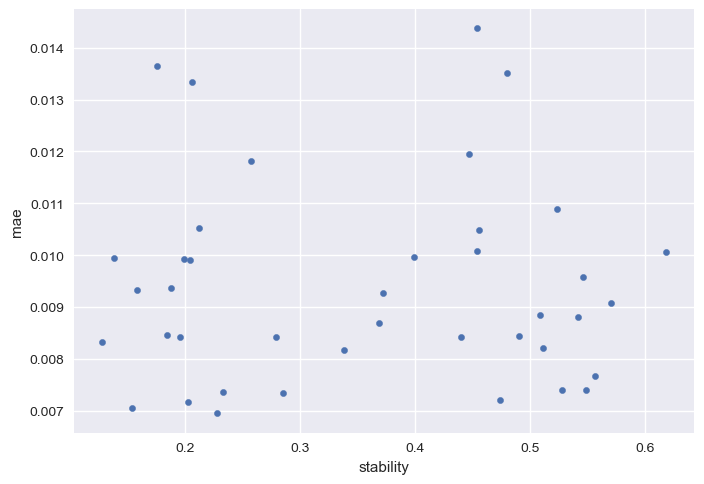

In [19]:
all_metrics_df.plot.scatter(y="mae", x="stability")

<Axes: xlabel='stability', ylabel='mae_2020'>

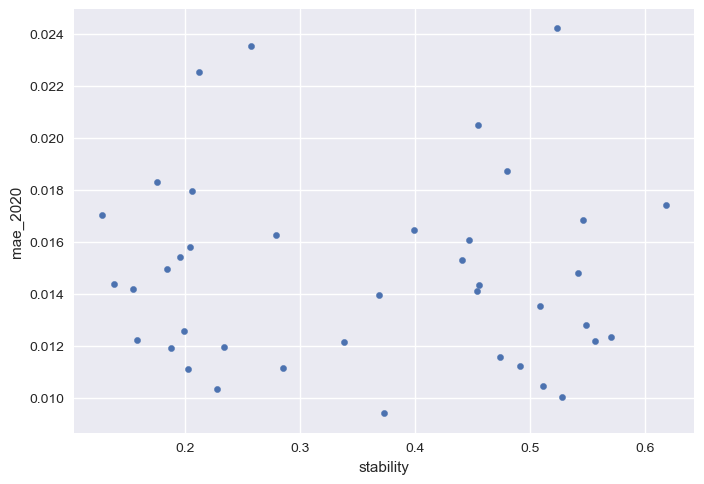

In [20]:
all_metrics_df.plot.scatter(y="mae_2020", x="stability")

<Axes: xlabel='stability', ylabel='mse'>

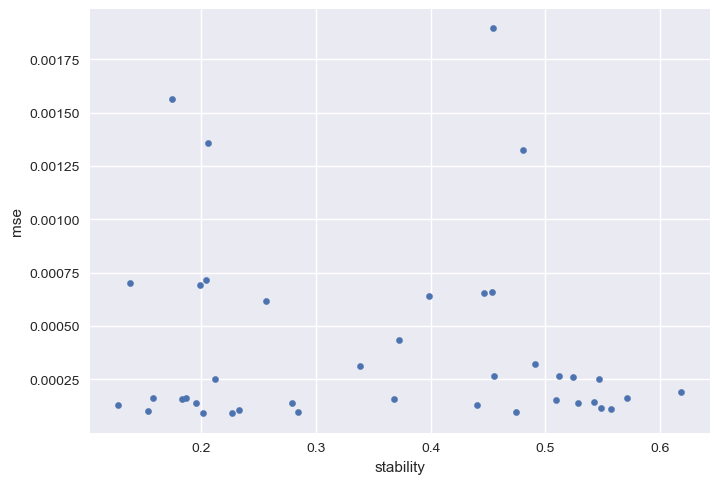

In [21]:
all_metrics_df.plot.scatter(y="mse", x="stability")

<Axes: xlabel='stability', ylabel='mse_2020'>

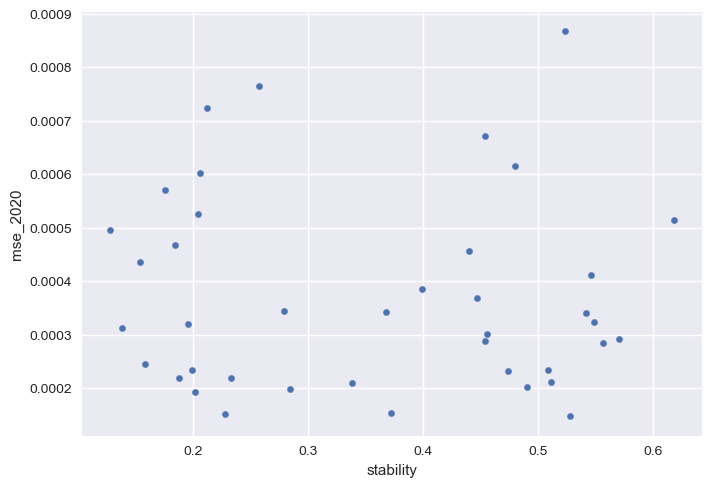

In [22]:
all_metrics_df.plot.scatter(y="mse_2020", x="stability")